#Example Generation and Access of an HDF5 File Using Pytables

Matthew Dahmer  
Chandra X-Ray Observatory  
Lead Thermal Subsystem Engineer  


This is intended to be a gentle introduction on how to generate and access hdf5 files using the pytables library. The codebase used by the Ska Engineering Archive, developed primarily by Tom Aldcroft and Jean Connelly, is naturally far more complex since it handles the generation and maintenance of the database, as well as a myriad of access methods, however I hope the examples below will serve as a starting point to understanding how the Ska Engineering Archive works.

----------

##Generate Data

Here we generate some realistic looking data to demonstrate a likely use case for this library.

We will create three datasets:
* times: floating point values from 1 to 1000 (unitless in this case)
* temps: Realistic looking data
* qual: Boolean array indicating whether or not the corresponding data is valid

I had some fun with the data generation below. A much simpler random distribution would have worked just as well for this demonstration, however this would not have looked realistic!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# This is required to show matplotlib plots within the notebook.
%matplotlib inline

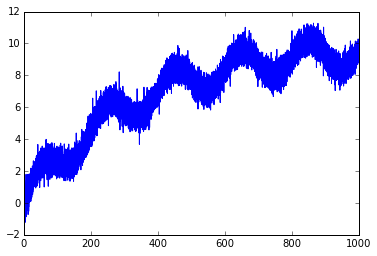

In [2]:
numpoints = 1e5
times = np.linspace(0, 1000, numpoints)
temps = 10*(1-1/np.exp(np.linspace(0, 3, numpoints))) + 1 * np.sin(2 * np.pi * times / 200)

# Add noise (a simple uniform distribution didn't look "real" enough).
for num in range(20, 50, 5):
    i = np.random.randint(num, size=numpoints) == 1
    temps[i] = temps[i] + (np.random.random(sum(i)) - 0.5) * num / 20

qual = np.random.randint(-30, 100, size=numpoints) > 0
    
plt.plot(times[qual],temps[qual])

Note the datatypes used.

In [3]:
times.dtype, temps.dtype, qual.dtype

(dtype('float64'), dtype('float64'), dtype('bool'))

This is the uncompressed size of the data we will save to the hdf5 file, compare this value to actual compressed file size produced in the next section. Additionally, try increasing the size of the numpoints variable above to see how python handles larger datasets (values larger than 1e7, the maximum value I tested, may cause stability issues depending on available video memory since the full dataset is plotted).

In [4]:
(64+64+1)*numpoints/8e6 # 1e6 bytes per megabyte * 8 bits per byte

1.6125

----

## Use the pytables library to create an hdf5 file.
This is the library used by the Ska Engineering Archive

Documentation can be found on the pytables website: http://www.pytables.org/index.html

In [5]:
import tables
import os

Define the filename, and the compression parameters.

In [6]:
filename = 'hdf5_example_file_pytables_lib.h5'
filters = tables.Filters(complevel=5, complib='zlib')

Delete the filename if it exists.

In [7]:
if os.path.exists(filename):
        os.unlink(filename)

Create the hdf5 file in write mode.

In [8]:
h5 = tables.openFile(filename, mode='w', filters=filters)

Define the datatype to be stored. It is also printed to output for inspection.

Note that the Ska engineering archive data uses 32 bit floats to store data to save disk and memory space, however all arithmetic should be done using 64 bit float datatypes to avoid excessive precision errors (e.g. compute the mean or standard deviation of a very large array of float32 vs float64). Below I use 64 bit floats from the start since we aren't as worried about disk space with this example.

In [9]:
h5type = tables.Atom.from_dtype(temps.dtype)
h5type

Float64Atom(shape=(), dflt=0.0)

Create the individual tables to store time, temperatures, and quality information. 

In the Ska Engineering Archive time is stored in a separate file to save space, however it is included in the same file here to simplify this example.

The shape must have one "0" dimension, in the case of the Ska engineering archive, the first dimension is set to zero. Further documentation for the EArray class can be found here:
http://www.pytables.org/usersguide/libref/homogenous_storage.html#the-earray-class

In [10]:
timearray = h5.createEArray(h5.root, 'times', h5type, (0,), title='times')
temparray = h5.createEArray(h5.root, 'temps', h5type, (0,), title='temps')
qualarray = h5.createEArray(h5.root, 'qual', tables.BoolAtom(), (0,), title='qual')

View the time array information.

In [11]:
timearray

/times (EArray(0,), shuffle, zlib(5)) 'times'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (8192,)

Save the data to the appropriate tables.

In [12]:
timearray.append(times)
temparray.append(temps)
qualarray.append(qual)

Ensure the data saved to the three tables are written to the file.

In [13]:
h5.flush()

Close the file

In [14]:
h5.close()

-----

## Use the pytables library to access data stored in an hdf5 file.


Open the hdf5 file created above in read mode and inspect its contents.

In [15]:
h5 = tables.openFile(filename, mode='r')
h5

File(filename=hdf5_example_file_pytables_lib.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=5, complib='zlib', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/qual (EArray(100000,), shuffle, zlib(5)) 'qual'
  atom := BoolAtom(shape=(), dflt=False)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (65536,)
/temps (EArray(100000,), shuffle, zlib(5)) 'temps'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (8192,)
/times (EArray(100000,), shuffle, zlib(5)) 'times'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (8192,)

Set the "table" variable to point to the data stored in the "temps" table in the hdf5 file. You don't need to create separate objects like this to access the underlying data (as shown below when generating the plot), however it can improve readability in a more complex code base.

In [16]:
table = h5.root.temps

View the first ten elements in the table array.

In [17]:
table[:10]

array([ 0.        ,  0.00061416,  0.00122831,  0.09362904,  0.00245659,
        0.34355375,  0.00368483,  0.00429894,  0.00491303,  0.00552712])

Plot the data and compare to the original plot above.

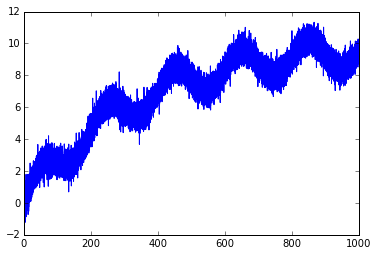

In [18]:
plt.plot(h5.root.times, h5.root.temps)

Close the hdf5 file.

In [19]:
h5.close()

Try accessing the table pointing to the "temps" array. You should find that this data is no longer accessible with the file closed.

In [20]:
table

<closed tables.earray.EArray at 0x107978ea8>